In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from PIL import Image
import os

# Cambia estos paths a tu estructura real
path_sketches = '/content/drive/MyDrive/GAN_Dataset/dataset/trainA'  # reales
path_real = '/content/drive/MyDrive/GAN_Dataset/dataset/trainB'      # dibujos
output_dir = '/content/drive/MyDrive/GAN_Dataset/dataset/combined'   # salida

# Crea carpeta de salida si no existe
os.makedirs(output_dir, exist_ok=True)

# Recorre todas las imágenes en trainA (sketches)
for filename in os.listdir(path_sketches):
    sketch_path = os.path.join(path_sketches, filename)
    real_path = os.path.join(path_real, filename)

    if not os.path.exists(real_path):
        print(f"No existe imagen real para: {filename}")
        continue

    try:
        # Abre y redimensiona ambas imágenes a 256x256
        sketch = Image.open(sketch_path).convert('RGB').resize((256, 256))
        real = Image.open(real_path).convert('RGB').resize((256, 256))

        # Crea una imagen combinada lado a lado (sketch | real)
        combined = Image.new('RGB', (512, 256))
        combined.paste(sketch, (0, 0))
        combined.paste(real, (256, 0))

        # Guarda imagen combinada
        combined.save(os.path.join(output_dir, filename))
        print(f" Imagen combinada guardada: {filename}")

    except Exception as e:
        print(f" Error con {filename}: {e}")


 Imagen combinada guardada: shoe001.jpg
 Imagen combinada guardada: shoe002.jpg
 Imagen combinada guardada: shoe003.jpg
 Imagen combinada guardada: shoe004.jpg
 Imagen combinada guardada: shoe005.jpg
 Imagen combinada guardada: shoe006.jpg
 Imagen combinada guardada: shoe007.jpg
 Imagen combinada guardada: shoe008.jpg
 Imagen combinada guardada: shoe009.jpg
 Imagen combinada guardada: shoe010.jpg
 Imagen combinada guardada: shoe011.jpg
 Imagen combinada guardada: shoe012.jpg
 Imagen combinada guardada: shoe013.jpg
 Imagen combinada guardada: shoe014.jpg
 Imagen combinada guardada: shoe015.jpg
 Imagen combinada guardada: shoe016.jpg
 Imagen combinada guardada: shoe017.jpg
 Imagen combinada guardada: shoe018.jpg
 Imagen combinada guardada: shoe019.jpg
 Imagen combinada guardada: shoe020.jpg
No existe imagen real para: shoe021.jpg
 Imagen combinada guardada: apple001.jpg
 Imagen combinada guardada: apple002.jpg
 Imagen combinada guardada: banana001.jpg
 Imagen combinada guardada: banana00

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-z481fs4j
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-z481fs4j
  Resolved https://github.com/tensorflow/examples.git to commit 6a3a323f3885f16085ad8335392f7ec836c677f4
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0.1744662746.606450842056059708696507624557970837683594229748-py3-none-any.whl size=301631 sha256=de5033f05a1b36c0d519eb006792ea1c061af48754abcaad7e74cedd26f10358
  Stored in directory: /tmp/pip-ephem-wheel-cache-6atrwu0s/wheels/91/9b/e8/6ae2ecc930bd726c578e35b313e987a687bc5ce03c3a42c2d5
Successfully built tensorflow-examples


In [ ]:
import wandb

wandb.init(project="pix2pix-tf", name="training_pix2pix_model")



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

In [ ]:
import tensorflow as tf
import os
from glob import glob
from tensorflow_examples.models.pix2pix import pix2pix
import matplotlib.pyplot as plt
import wandb

# Configuración
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256
PATH = "/content/drive/MyDrive/GAN_Dataset/dataset/combined/"

# Preprocesamiento
def load(image_file):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_jpeg(image)

    w = tf.shape(image)[1]
    w = w // 2
    input_image = image[:, :w, :]
    real_image = image[:, w:, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width])
    real_image = tf.image.resize(real_image, [height, width])
    return input_image, real_image

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

@tf.function()
def random_jitter(input_image, real_image):
    input_image, real_image = resize(input_image, real_image, 286, 286)
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    input_image, real_image = cropped_image[0], cropped_image[1]

    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)

    return input_image, real_image

def load_image_train(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

def load_image_test(image_file):
    input_image, real_image = load(image_file)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

# Crear datasets
image_files = glob(os.path.join(PATH, '*.jpg'))

train_dataset = tf.data.Dataset.from_tensor_slices(image_files)
train_dataset = train_dataset.map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Define el generador y discriminador
OUTPUT_CHANNELS = 3
generator = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')
discriminator = pix2pix.discriminator(norm_type='batchnorm', target=True)

# Losses y optimizadores
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
LAMBDA = 100

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    return gan_loss + (LAMBDA * l1_loss)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)
    generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
    return real_loss + generated_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Checkpoint
checkpoint_dir = './training_checkpoints_pix2pix'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Entrenamiento
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)

        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    generator_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    discriminator_gradients = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

    return gen_loss, disc_loss

best_gen_loss = float('inf')


def fit(train_ds, steps):
    global best_gen_loss  # para poder modificarla dentro de la función

    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        gen_loss, disc_loss = train_step(input_image, target)

        # Logging a W&B
        if step % 10 == 0:
            wandb.log({
                "step": step.numpy(),
                "gen_loss": gen_loss.numpy(),
                "disc_loss": disc_loss.numpy()
            })

        # Guardar mejor modelo
        if gen_loss < best_gen_loss:
            best_gen_loss = gen_loss
            generator.save("/content/drive/MyDrive/GAN_Dataset/best_generator_pix2pix.h5")
            print(f"[{step.numpy()}] Nuevo mejor modelo guardado. gen_loss: {gen_loss.numpy()}")

        if step % 100 == 0:
            print(f"Paso {step.numpy()} completado. Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}")



In [ ]:
# Entrena el modelo
fit(train_dataset, steps=100_000)

# Guarda el modelo
# generator.save("generator_pix2pix_model.h5")

[0] Nuevo mejor modelo guardado. gen_loss: 61.02618408203125
Paso 0 completado. Generator Loss: 61.02618408203125, Discriminator Loss: 1.7064759731292725


[2] Nuevo mejor modelo guardado. gen_loss: 59.085575103759766


[4] Nuevo mejor modelo guardado. gen_loss: 55.57794189453125


[5] Nuevo mejor modelo guardado. gen_loss: 53.401973724365234


[6] Nuevo mejor modelo guardado. gen_loss: 39.68468475341797


[10] Nuevo mejor modelo guardado. gen_loss: 33.9482536315918


[15] Nuevo mejor modelo guardado. gen_loss: 33.72360610961914


[18] Nuevo mejor modelo guardado. gen_loss: 22.423025131225586
[21] Nuevo mejor modelo guardado. gen_loss: 21.994714736938477


[31] Nuevo mejor modelo guardado. gen_loss: 20.631271362304688


[32] Nuevo mejor modelo guardado. gen_loss: 17.838102340698242


[33] Nuevo mejor modelo guardado. gen_loss: 17.31521987915039
[38] Nuevo mejor modelo guardado. gen_loss: 16.66398811340332


[59] Nuevo mejor modelo guardado. gen_loss: 14.78360366821289


[73] Nuevo mejor modelo guardado. gen_loss: 14.321139335632324


[76] Nuevo mejor modelo guardado. gen_loss: 14.218626022338867
[79] Nuevo mejor modelo guardado. gen_loss: 12.905838012695312


Paso 100 completado. Generator Loss: 20.02263641357422, Discriminator Loss: 1.1508374214172363
[102] Nuevo mejor modelo guardado. gen_loss: 12.471711158752441


Paso 200 completado. Generator Loss: 15.070173263549805, Discriminator Loss: 0.8032687306404114
[203] Nuevo mejor modelo guardado. gen_loss: 11.001825332641602
Paso 300 completado. Generator Loss: 19.411895751953125, Discriminator Loss: 1.4252948760986328
Paso 400 completado. Generator Loss: 14.21961498260498, Discriminator Loss: 1.4548254013061523
Paso 500 completado. Generator Loss: 27.763538360595703, Discriminator Loss: 0.2698730230331421
Paso 600 completado. Generator Loss: 20.921226501464844, Discriminator Loss: 0.5621377825737
Paso 700 completado. Generator Loss: 14.484692573547363, Discriminator Loss: 0.8851233124732971
Paso 800 completado. Generator Loss: 29.24649429321289, Discriminator Loss: 0.38370704650878906
Paso 900 completado. Generator Loss: 30.954133987426758, Discriminator Loss: 0.38296079635620117


[929] Nuevo mejor modelo guardado. gen_loss: 10.590062141418457
Paso 1000 completado. Generator Loss: 30.719709396362305, Discriminator Loss: 0.5226532816886902
Paso 1100 completado. Generator Loss: 24.92888069152832, Discriminator Loss: 0.5430486798286438


[1139] Nuevo mejor modelo guardado. gen_loss: 9.451959609985352
Paso 1200 completado. Generator Loss: 19.91327476501465, Discriminator Loss: 0.3933173418045044


[1208] Nuevo mejor modelo guardado. gen_loss: 9.0232515335083
Paso 1300 completado. Generator Loss: 30.39992904663086, Discriminator Loss: 0.8414151668548584


[1314] Nuevo mejor modelo guardado. gen_loss: 8.804207801818848
Paso 1400 completado. Generator Loss: 15.6110200881958, Discriminator Loss: 1.0058157444000244


[1490] Nuevo mejor modelo guardado. gen_loss: 8.164504051208496
Paso 1500 completado. Generator Loss: 22.255577087402344, Discriminator Loss: 2.102618932723999


[1527] Nuevo mejor modelo guardado. gen_loss: 7.8444952964782715


[1537] Nuevo mejor modelo guardado. gen_loss: 7.562108039855957
Paso 1600 completado. Generator Loss: 8.217181205749512, Discriminator Loss: 1.336337924003601


[1698] Nuevo mejor modelo guardado. gen_loss: 7.538357734680176
Paso 1700 completado. Generator Loss: 17.509521484375, Discriminator Loss: 1.2004413604736328
Paso 1800 completado. Generator Loss: 16.000457763671875, Discriminator Loss: 0.4364051818847656


[1835] Nuevo mejor modelo guardado. gen_loss: 6.508028030395508
Paso 1900 completado. Generator Loss: 19.503019332885742, Discriminator Loss: 1.9732944965362549


[1946] Nuevo mejor modelo guardado. gen_loss: 6.416129112243652
Paso 2000 completado. Generator Loss: 8.368183135986328, Discriminator Loss: 1.2692972421646118
Paso 2100 completado. Generator Loss: 27.056066513061523, Discriminator Loss: 0.28918173909187317


Paso 2200 completado. Generator Loss: 16.346967697143555, Discriminator Loss: 0.3855041265487671
[2207] Nuevo mejor modelo guardado. gen_loss: 6.395923614501953


[2264] Nuevo mejor modelo guardado. gen_loss: 6.251303672790527
Paso 2300 completado. Generator Loss: 13.220848083496094, Discriminator Loss: 0.7515978813171387


[2319] Nuevo mejor modelo guardado. gen_loss: 5.90966796875


[2372] Nuevo mejor modelo guardado. gen_loss: 5.759034633636475
Paso 2400 completado. Generator Loss: 13.670892715454102, Discriminator Loss: 0.34067031741142273
Paso 2500 completado. Generator Loss: 11.153847694396973, Discriminator Loss: 1.2682464122772217
Paso 2600 completado. Generator Loss: 21.09665870666504, Discriminator Loss: 1.009019136428833
Paso 2700 completado. Generator Loss: 21.266511917114258, Discriminator Loss: 0.3446354269981384


[2712] Nuevo mejor modelo guardado. gen_loss: 5.211331367492676
Paso 2800 completado. Generator Loss: 12.6574068069458, Discriminator Loss: 1.1462315320968628
Paso 2900 completado. Generator Loss: 14.741276741027832, Discriminator Loss: 0.6278901100158691
Paso 3000 completado. Generator Loss: 14.766679763793945, Discriminator Loss: 0.2831064462661743
Paso 3100 completado. Generator Loss: 11.23698616027832, Discriminator Loss: 0.4815976917743683
Paso 3200 completado. Generator Loss: 9.588346481323242, Discriminator Loss: 1.6209744215011597
Paso 3300 completado. Generator Loss: 16.577314376831055, Discriminator Loss: 0.7726513743400574
Paso 3400 completado. Generator Loss: 13.023726463317871, Discriminator Loss: 0.7159638404846191
Paso 3500 completado. Generator Loss: 17.31586265563965, Discriminator Loss: 0.6026098728179932
Paso 3600 completado. Generator Loss: 6.652586460113525, Discriminator Loss: 1.845738410949707
Paso 3700 completado. Generator Loss: 15.647506713867188, Discriminato

[3866] Nuevo mejor modelo guardado. gen_loss: 5.187969207763672
Paso 3900 completado. Generator Loss: 10.070666313171387, Discriminator Loss: 0.7007948160171509
Paso 4000 completado. Generator Loss: 14.964752197265625, Discriminator Loss: 0.8242657780647278
Paso 4100 completado. Generator Loss: 11.650216102600098, Discriminator Loss: 2.325392484664917


[4129] Nuevo mejor modelo guardado. gen_loss: 4.882690906524658


Paso 4200 completado. Generator Loss: 10.933777809143066, Discriminator Loss: 0.7384592294692993
[4203] Nuevo mejor modelo guardado. gen_loss: 4.532012462615967
Paso 4300 completado. Generator Loss: 7.714410781860352, Discriminator Loss: 1.2267441749572754
Paso 4400 completado. Generator Loss: 15.372979164123535, Discriminator Loss: 0.6663153767585754
Paso 4500 completado. Generator Loss: 12.24407958984375, Discriminator Loss: 0.9561402797698975
Paso 4600 completado. Generator Loss: 15.768315315246582, Discriminator Loss: 0.20096585154533386
Paso 4700 completado. Generator Loss: 7.41497802734375, Discriminator Loss: 1.017582893371582
Paso 4800 completado. Generator Loss: 15.725467681884766, Discriminator Loss: 0.9946022033691406
Paso 4900 completado. Generator Loss: 14.86959457397461, Discriminator Loss: 0.8512442708015442
Paso 5000 completado. Generator Loss: 11.891695976257324, Discriminator Loss: 0.43938589096069336
Paso 5100 completado. Generator Loss: 9.552188873291016, Discrimina

[5341] Nuevo mejor modelo guardado. gen_loss: 4.43309211730957
Paso 5400 completado. Generator Loss: 15.898524284362793, Discriminator Loss: 1.0075082778930664
Paso 5500 completado. Generator Loss: 9.256288528442383, Discriminator Loss: 0.8160824179649353
Paso 5600 completado. Generator Loss: 14.160327911376953, Discriminator Loss: 1.6350497007369995
Paso 5700 completado. Generator Loss: 11.117074966430664, Discriminator Loss: 1.4788786172866821
Paso 5800 completado. Generator Loss: 13.752725601196289, Discriminator Loss: 0.5420234203338623
Paso 5900 completado. Generator Loss: 14.228169441223145, Discriminator Loss: 0.2264547049999237
Paso 6000 completado. Generator Loss: 12.652881622314453, Discriminator Loss: 0.8867785930633545
Paso 6100 completado. Generator Loss: 16.40073013305664, Discriminator Loss: 0.4259432554244995
Paso 6200 completado. Generator Loss: 16.531097412109375, Discriminator Loss: 0.3112095892429352
Paso 6300 completado. Generator Loss: 16.44902801513672, Discrimin

[6519] Nuevo mejor modelo guardado. gen_loss: 4.432577133178711
Paso 6600 completado. Generator Loss: 12.681411743164062, Discriminator Loss: 1.298223614692688
Paso 6700 completado. Generator Loss: 14.244792938232422, Discriminator Loss: 0.800201952457428
Paso 6800 completado. Generator Loss: 12.27767562866211, Discriminator Loss: 0.9792148470878601
Paso 6900 completado. Generator Loss: 9.954910278320312, Discriminator Loss: 0.7241776585578918
Paso 7000 completado. Generator Loss: 11.953808784484863, Discriminator Loss: 0.400718629360199
Paso 7100 completado. Generator Loss: 12.6705322265625, Discriminator Loss: 0.6648609042167664
Paso 7200 completado. Generator Loss: 9.639575958251953, Discriminator Loss: 0.7042881846427917


[7243] Nuevo mejor modelo guardado. gen_loss: 4.081704139709473
Paso 7300 completado. Generator Loss: 13.61528491973877, Discriminator Loss: 0.4757879972457886
Paso 7400 completado. Generator Loss: 4.801913738250732, Discriminator Loss: 1.4375731945037842
Paso 7500 completado. Generator Loss: 10.25106430053711, Discriminator Loss: 0.646613597869873
Paso 7600 completado. Generator Loss: 11.479098320007324, Discriminator Loss: 2.753262996673584
Paso 7700 completado. Generator Loss: 13.018208503723145, Discriminator Loss: 0.5719791650772095
Paso 7800 completado. Generator Loss: 13.88402271270752, Discriminator Loss: 0.7434754967689514
Paso 7900 completado. Generator Loss: 13.68604564666748, Discriminator Loss: 0.19247184693813324
Paso 8000 completado. Generator Loss: 13.840757369995117, Discriminator Loss: 0.7121018171310425
Paso 8100 completado. Generator Loss: 14.51685905456543, Discriminator Loss: 0.1448238492012024
Paso 8200 completado. Generator Loss: 11.809880256652832, Discriminato

[9285] Nuevo mejor modelo guardado. gen_loss: 3.820507287979126
Paso 9300 completado. Generator Loss: 12.224242210388184, Discriminator Loss: 1.0297374725341797
Paso 9400 completado. Generator Loss: 13.261237144470215, Discriminator Loss: 0.1946888267993927
Paso 9500 completado. Generator Loss: 11.972738265991211, Discriminator Loss: 0.8396414518356323
Paso 9600 completado. Generator Loss: 13.632434844970703, Discriminator Loss: 0.4506473243236542
Paso 9700 completado. Generator Loss: 11.400833129882812, Discriminator Loss: 0.4951753616333008
Paso 9800 completado. Generator Loss: 11.064839363098145, Discriminator Loss: 0.4684763550758362


[9894] Nuevo mejor modelo guardado. gen_loss: 3.7857134342193604
Paso 9900 completado. Generator Loss: 8.714252471923828, Discriminator Loss: 0.33757078647613525
Paso 10000 completado. Generator Loss: 11.125859260559082, Discriminator Loss: 0.7635775804519653
Paso 10100 completado. Generator Loss: 8.731746673583984, Discriminator Loss: 0.9031014442443848


[10146] Nuevo mejor modelo guardado. gen_loss: 3.784921884536743
Paso 10200 completado. Generator Loss: 7.015257358551025, Discriminator Loss: 1.3739460706710815
Paso 10300 completado. Generator Loss: 4.885705947875977, Discriminator Loss: 0.8666837215423584
Paso 10400 completado. Generator Loss: 5.999080657958984, Discriminator Loss: 0.6692245602607727
Paso 10500 completado. Generator Loss: 10.250495910644531, Discriminator Loss: 0.45920228958129883


[10557] Nuevo mejor modelo guardado. gen_loss: 3.6691131591796875
Paso 10600 completado. Generator Loss: 6.893999099731445, Discriminator Loss: 4.022319316864014
Paso 10700 completado. Generator Loss: 11.180964469909668, Discriminator Loss: 0.9466639757156372
Paso 10800 completado. Generator Loss: 11.278080940246582, Discriminator Loss: 0.48987194895744324
Paso 10900 completado. Generator Loss: 10.372880935668945, Discriminator Loss: 0.5261726975440979


[10912] Nuevo mejor modelo guardado. gen_loss: 3.66131591796875
Paso 11000 completado. Generator Loss: 13.335949897766113, Discriminator Loss: 0.5287997722625732
Paso 11100 completado. Generator Loss: 14.411666870117188, Discriminator Loss: 0.3521573543548584
Paso 11200 completado. Generator Loss: 10.170090675354004, Discriminator Loss: 0.8075098395347595
Paso 11300 completado. Generator Loss: 5.344085693359375, Discriminator Loss: 1.059769868850708
Paso 11400 completado. Generator Loss: 9.7864351272583, Discriminator Loss: 0.753520131111145
Paso 11500 completado. Generator Loss: 10.607939720153809, Discriminator Loss: 0.697190523147583
Paso 11600 completado. Generator Loss: 10.016694068908691, Discriminator Loss: 0.46554136276245117
Paso 11700 completado. Generator Loss: 13.02542781829834, Discriminator Loss: 0.40038037300109863
Paso 11800 completado. Generator Loss: 12.942893028259277, Discriminator Loss: 0.3607531189918518
Paso 11900 completado. Generator Loss: 11.056811332702637, D

[12320] Nuevo mejor modelo guardado. gen_loss: 3.5143237113952637
Paso 12400 completado. Generator Loss: 15.479462623596191, Discriminator Loss: 0.7357610464096069
Paso 12500 completado. Generator Loss: 10.885744094848633, Discriminator Loss: 1.2294780015945435
Paso 12600 completado. Generator Loss: 13.147967338562012, Discriminator Loss: 0.7889086008071899
Paso 12700 completado. Generator Loss: 7.0741167068481445, Discriminator Loss: 1.064980387687683
Paso 12800 completado. Generator Loss: 9.373416900634766, Discriminator Loss: 0.43316757678985596
Paso 12900 completado. Generator Loss: 13.476311683654785, Discriminator Loss: 0.4260801672935486
Paso 13000 completado. Generator Loss: 15.373520851135254, Discriminator Loss: 0.18684932589530945
Paso 13100 completado. Generator Loss: 9.568859100341797, Discriminator Loss: 1.7494243383407593
Paso 13200 completado. Generator Loss: 13.785929679870605, Discriminator Loss: 0.5717308521270752
Paso 13300 completado. Generator Loss: 6.702293395996

Paso 14200 completado. Generator Loss: 12.825406074523926, Discriminator Loss: 0.2619912922382355
[14204] Nuevo mejor modelo guardado. gen_loss: 3.4148828983306885
Paso 14300 completado. Generator Loss: 10.307040214538574, Discriminator Loss: 0.6196110248565674
Paso 14400 completado. Generator Loss: 8.3809175491333, Discriminator Loss: 0.8620905876159668
Paso 14500 completado. Generator Loss: 9.434433937072754, Discriminator Loss: 0.8422477841377258
Paso 14600 completado. Generator Loss: 11.686707496643066, Discriminator Loss: 0.5036835074424744
Paso 14700 completado. Generator Loss: 10.758458137512207, Discriminator Loss: 1.37152099609375
Paso 14800 completado. Generator Loss: 9.407119750976562, Discriminator Loss: 0.5121293067932129
Paso 14900 completado. Generator Loss: 12.630805969238281, Discriminator Loss: 0.690127968788147
Paso 15000 completado. Generator Loss: 11.122014999389648, Discriminator Loss: 0.699844479560852
Paso 15100 completado. Generator Loss: 11.68450927734375, Dis

[15765] Nuevo mejor modelo guardado. gen_loss: 3.2712807655334473
Paso 15800 completado. Generator Loss: 7.231285095214844, Discriminator Loss: 0.5100113153457642
Paso 15900 completado. Generator Loss: 8.897193908691406, Discriminator Loss: 0.9941049814224243


[15926] Nuevo mejor modelo guardado. gen_loss: 3.1206753253936768
Paso 16000 completado. Generator Loss: 11.230634689331055, Discriminator Loss: 0.705704927444458
Paso 16100 completado. Generator Loss: 6.467241287231445, Discriminator Loss: 1.3809106349945068
Paso 16200 completado. Generator Loss: 8.883734703063965, Discriminator Loss: 0.8836984634399414
Paso 16300 completado. Generator Loss: 9.606830596923828, Discriminator Loss: 0.5361419916152954
Paso 16400 completado. Generator Loss: 6.502230644226074, Discriminator Loss: 1.0943124294281006
Paso 16500 completado. Generator Loss: 7.10750150680542, Discriminator Loss: 1.0054384469985962
Paso 16600 completado. Generator Loss: 10.569485664367676, Discriminator Loss: 0.8020607829093933
Paso 16700 completado. Generator Loss: 12.037083625793457, Discriminator Loss: 0.6817203760147095
Paso 16800 completado. Generator Loss: 9.946155548095703, Discriminator Loss: 1.2805662155151367
Paso 16900 completado. Generator Loss: 11.475882530212402, D

[23110] Nuevo mejor modelo guardado. gen_loss: 2.9260802268981934
Paso 23200 completado. Generator Loss: 8.621125221252441, Discriminator Loss: 0.918509840965271
Paso 23300 completado. Generator Loss: 10.755097389221191, Discriminator Loss: 0.498254656791687


[23389] Nuevo mejor modelo guardado. gen_loss: 2.8789784908294678
Paso 23400 completado. Generator Loss: 10.61442756652832, Discriminator Loss: 0.9997337460517883
Paso 23500 completado. Generator Loss: 5.751022815704346, Discriminator Loss: 0.9691091179847717
Paso 23600 completado. Generator Loss: 5.364161491394043, Discriminator Loss: 0.7124311923980713
Paso 23700 completado. Generator Loss: 10.06994915008545, Discriminator Loss: 0.8262020349502563
Paso 23800 completado. Generator Loss: 8.657898902893066, Discriminator Loss: 0.7763602137565613
Paso 23900 completado. Generator Loss: 10.142730712890625, Discriminator Loss: 2.46987247467041
Paso 24000 completado. Generator Loss: 11.296427726745605, Discriminator Loss: 1.102990746498108
Paso 24100 completado. Generator Loss: 9.876015663146973, Discriminator Loss: 1.1646758317947388
Paso 24200 completado. Generator Loss: 6.485607624053955, Discriminator Loss: 1.075927734375
Paso 24300 completado. Generator Loss: 10.431716918945312, Discrim

[25441] Nuevo mejor modelo guardado. gen_loss: 2.8504140377044678
Paso 25500 completado. Generator Loss: 9.752171516418457, Discriminator Loss: 0.6774803400039673
Paso 25600 completado. Generator Loss: 7.329532623291016, Discriminator Loss: 1.3124579191207886
Paso 25700 completado. Generator Loss: 7.328863143920898, Discriminator Loss: 1.6795785427093506
Paso 25800 completado. Generator Loss: 13.323029518127441, Discriminator Loss: 0.5936546325683594
Paso 25900 completado. Generator Loss: 10.501396179199219, Discriminator Loss: 0.9753313064575195
Paso 26000 completado. Generator Loss: 10.387310028076172, Discriminator Loss: 0.782869279384613
Paso 26100 completado. Generator Loss: 4.273568153381348, Discriminator Loss: 0.7825195789337158
Paso 26200 completado. Generator Loss: 9.844834327697754, Discriminator Loss: 0.9075157046318054
Paso 26300 completado. Generator Loss: 5.889263153076172, Discriminator Loss: 0.8467844128608704
Paso 26400 completado. Generator Loss: 6.316755294799805, D

[31229] Nuevo mejor modelo guardado. gen_loss: 2.7839596271514893
Paso 31300 completado. Generator Loss: 3.5451126098632812, Discriminator Loss: 1.2534904479980469
Paso 31400 completado. Generator Loss: 5.891226291656494, Discriminator Loss: 0.9806333780288696
Paso 31500 completado. Generator Loss: 9.993558883666992, Discriminator Loss: 0.7378092408180237
Paso 31600 completado. Generator Loss: 9.286558151245117, Discriminator Loss: 0.3771829605102539
Paso 31700 completado. Generator Loss: 11.902517318725586, Discriminator Loss: 0.7126693725585938
Paso 31800 completado. Generator Loss: 15.238622665405273, Discriminator Loss: 0.36917048692703247
Paso 31900 completado. Generator Loss: 13.457051277160645, Discriminator Loss: 0.7191117405891418
Paso 32000 completado. Generator Loss: 11.170122146606445, Discriminator Loss: 0.4383501708507538
Paso 32100 completado. Generator Loss: 10.072027206420898, Discriminator Loss: 0.45594072341918945
Paso 32200 completado. Generator Loss: 9.116330146789

[34886] Nuevo mejor modelo guardado. gen_loss: 2.7554402351379395
Paso 34900 completado. Generator Loss: 6.157310962677002, Discriminator Loss: 1.8495855331420898
Paso 35000 completado. Generator Loss: 7.199846267700195, Discriminator Loss: 0.5849323272705078
Paso 35100 completado. Generator Loss: 10.236113548278809, Discriminator Loss: 0.7421324253082275


[35160] Nuevo mejor modelo guardado. gen_loss: 2.6966371536254883
Paso 35200 completado. Generator Loss: 5.524221897125244, Discriminator Loss: 0.7351700067520142
Paso 35300 completado. Generator Loss: 10.420990943908691, Discriminator Loss: 0.5592253804206848
Paso 35400 completado. Generator Loss: 7.298816680908203, Discriminator Loss: 1.318761944770813
Paso 35500 completado. Generator Loss: 11.201807022094727, Discriminator Loss: 0.36842262744903564
Paso 35600 completado. Generator Loss: 10.614492416381836, Discriminator Loss: 0.9743593335151672
Paso 35700 completado. Generator Loss: 8.611912727355957, Discriminator Loss: 0.5197194218635559
Paso 35800 completado. Generator Loss: 12.210325241088867, Discriminator Loss: 0.3145167827606201
Paso 35900 completado. Generator Loss: 8.810770034790039, Discriminator Loss: 0.5404188632965088


[35933] Nuevo mejor modelo guardado. gen_loss: 2.644270420074463
Paso 36000 completado. Generator Loss: 10.384892463684082, Discriminator Loss: 0.46857041120529175
Paso 36100 completado. Generator Loss: 3.9939193725585938, Discriminator Loss: 0.9484543204307556
Paso 36200 completado. Generator Loss: 6.542301177978516, Discriminator Loss: 1.0914647579193115
Paso 36300 completado. Generator Loss: 5.827670097351074, Discriminator Loss: 0.8226370811462402
Paso 36400 completado. Generator Loss: 4.746353626251221, Discriminator Loss: 0.6462560296058655
Paso 36500 completado. Generator Loss: 8.616321563720703, Discriminator Loss: 1.0991085767745972
Paso 36600 completado. Generator Loss: 9.059337615966797, Discriminator Loss: 0.8929891586303711
Paso 36700 completado. Generator Loss: 9.472800254821777, Discriminator Loss: 0.5957474708557129
Paso 36800 completado. Generator Loss: 5.470904350280762, Discriminator Loss: 0.623598039150238
Paso 36900 completado. Generator Loss: 9.395191192626953, Di

[39308] Nuevo mejor modelo guardado. gen_loss: 2.520594835281372
Paso 39400 completado. Generator Loss: 9.189427375793457, Discriminator Loss: 1.0717538595199585
Paso 39500 completado. Generator Loss: 11.5899658203125, Discriminator Loss: 0.6598675847053528
Paso 39600 completado. Generator Loss: 10.273193359375, Discriminator Loss: 0.603848934173584
Paso 39700 completado. Generator Loss: 10.711910247802734, Discriminator Loss: 0.9199620485305786
Paso 39800 completado. Generator Loss: 3.4945850372314453, Discriminator Loss: 1.0506019592285156
Paso 39900 completado. Generator Loss: 9.848414421081543, Discriminator Loss: 0.36957335472106934
Paso 40000 completado. Generator Loss: 7.216982364654541, Discriminator Loss: 0.9780594110488892
Paso 40100 completado. Generator Loss: 13.153995513916016, Discriminator Loss: 0.31340569257736206
Paso 40200 completado. Generator Loss: 11.298341751098633, Discriminator Loss: 0.6134098768234253
Paso 40300 completado. Generator Loss: 12.050151824951172, D

[46610] Nuevo mejor modelo guardado. gen_loss: 2.3413052558898926
Paso 46700 completado. Generator Loss: 13.863468170166016, Discriminator Loss: 0.3812696635723114
Paso 46800 completado. Generator Loss: 4.299847602844238, Discriminator Loss: 1.1287541389465332
Paso 46900 completado. Generator Loss: 10.509370803833008, Discriminator Loss: 0.4834281802177429
Paso 47000 completado. Generator Loss: 8.599119186401367, Discriminator Loss: 1.3036046028137207
Paso 47100 completado. Generator Loss: 9.425554275512695, Discriminator Loss: 0.6822690367698669
Paso 47200 completado. Generator Loss: 7.724623680114746, Discriminator Loss: 0.4334544837474823
Paso 47300 completado. Generator Loss: 8.495139122009277, Discriminator Loss: 0.4533476233482361
Paso 47400 completado. Generator Loss: 8.838571548461914, Discriminator Loss: 0.4997599124908447
Paso 47500 completado. Generator Loss: 11.198884963989258, Discriminator Loss: 1.032085657119751
Paso 47600 completado. Generator Loss: 10.792770385742188, 

[71163] Nuevo mejor modelo guardado. gen_loss: 2.328885555267334
Paso 71200 completado. Generator Loss: 7.769425392150879, Discriminator Loss: 0.6563177108764648
Paso 71300 completado. Generator Loss: 9.418941497802734, Discriminator Loss: 0.6203701496124268
Paso 71400 completado. Generator Loss: 4.976665496826172, Discriminator Loss: 3.496248483657837
Paso 71500 completado. Generator Loss: 9.915871620178223, Discriminator Loss: 0.486887127161026
Paso 71600 completado. Generator Loss: 9.919370651245117, Discriminator Loss: 0.3017060458660126
Paso 71700 completado. Generator Loss: 8.63125991821289, Discriminator Loss: 1.4560178518295288
Paso 71800 completado. Generator Loss: 8.763917922973633, Discriminator Loss: 1.0519561767578125
Paso 71900 completado. Generator Loss: 12.640145301818848, Discriminator Loss: 0.3113469183444977
Paso 72000 completado. Generator Loss: 8.676050186157227, Discriminator Loss: 0.6122264266014099
Paso 72100 completado. Generator Loss: 11.285932540893555, Discr

[82231] Nuevo mejor modelo guardado. gen_loss: 2.2483251094818115
Paso 82300 completado. Generator Loss: 9.96054458618164, Discriminator Loss: 0.8124749064445496
Paso 82400 completado. Generator Loss: 6.608625888824463, Discriminator Loss: 0.23336806893348694
Paso 82500 completado. Generator Loss: 12.683126449584961, Discriminator Loss: 0.8595371842384338
Paso 82600 completado. Generator Loss: 5.669878959655762, Discriminator Loss: 0.6321965456008911
Paso 82700 completado. Generator Loss: 10.536056518554688, Discriminator Loss: 0.1972045600414276
Paso 82800 completado. Generator Loss: 11.817352294921875, Discriminator Loss: 0.7500979900360107
Paso 82900 completado. Generator Loss: 8.637655258178711, Discriminator Loss: 0.4588567018508911
Paso 83000 completado. Generator Loss: 13.701770782470703, Discriminator Loss: 0.2639957070350647
Paso 83100 completado. Generator Loss: 8.707324981689453, Discriminator Loss: 0.8026854991912842
Paso 83200 completado. Generator Loss: 12.235623359680176

PRUEBA

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

# Cargar el generador ya entrenado
generator = tf.keras.models.load_model("/content/drive/MyDrive/GAN_Dataset/best_generator_pix2pix.h5", compile=False)


In [ ]:

generator.save("/content/drive/MyDrive/GAN_Dataset/generator_pix2pix_model.h5")


In [ ]:
def load_input_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image)
    image = tf.image.resize(image, [256, 256])
    image = (tf.cast(image, tf.float32) / 127.5) - 1  # Normalizar [-1, 1]
    image = tf.expand_dims(image, axis=0)  # (1, 256, 256, 3)
    return image

In [ ]:
def generate_image(model, input_image):
    prediction = model(input_image, training=False)
    return prediction[0]

In [ ]:
def display(input_image, predicted_image):
    plt.figure(figsize=(12, 6))

    display_list = [input_image[0], predicted_image]
    title = ['real', 'Dibujo']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        image = display_list[i]
        image = (image + 1) / 2  # Desnormaliza de [-1, 1] a [0, 1]
        plt.imshow(image)
        plt.axis('off')
    plt.show()

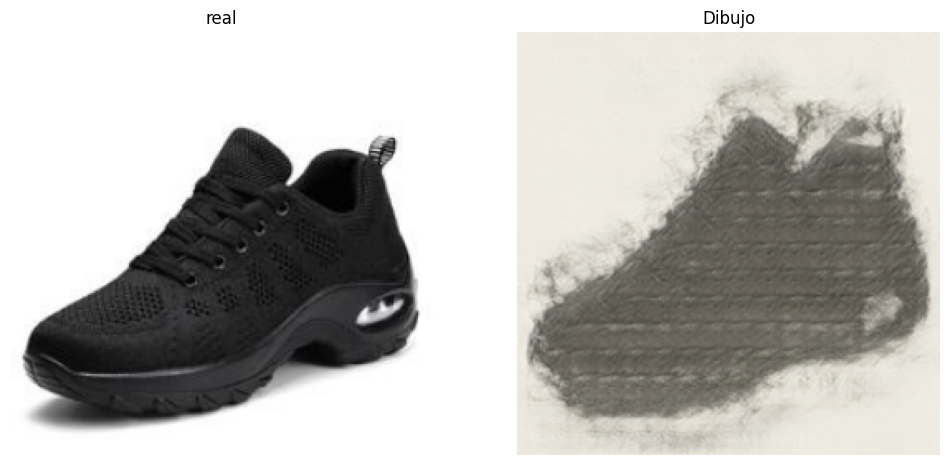

In [ ]:
# Cargar imagen de prueba
input_img = load_input_image("/content/drive/MyDrive/GAN_Dataset/dataset/trainA/shoe020.jpg")

# Generar resultado
output_img = generate_image(generator, input_img)

# Mostrar resultados
display(input_img, output_img)